# Python for Computational Linguists 2.3: Part-of-speech Tagging

Welcome to module 2.3. In this module, we will use the Python library `NLTK` to erxplore part-of-speech (POS) tagging, an important early NLP application.
By the end of the module, you should be able to
- understand the definition of POS tagging, tagset and tagged corpora with examples.
- use data structure `dictionary` to store various information for POS tagging.
- know how to split the data into training and test set, and the evaluation metrics for POS tagging.
- build different types of tagging models in NLTK. 
- get an overview of Viterbi algorithm for POS tagging decoding/inference.


Let's start with a pre-module quiz to review POS tagging.

## ❓ Pre-module quiz

Which descriptions are true about POS tagging?

A. POS tagging is a task of text classification (similar to document classification), where we assign a single label to the input text sequence.

B. POS tagging is a task of sequence labelling, where we assign a label to each word/token of the input text sequence.

C. We can use POS tagging to disambiguate certain words/tokens.

D. We can use POS tagging to solve syntactic ambiguity, e.g. PP atachment.

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
  <p>B, C.</p>
  <p>POS tagging is the task of assigning a word category (POS tag) to each word from the input sequence, so it is a sequence labelling task.</p>
  <p>POS tagging can be used to address lexical ambiguity such as heterophones: CONtent (noun) and conTent (adjective), but for higher level syntactic ambiguity, we need parsing to solve it.</p>
</details> 

## What is POS tagging?
For each word in context, we can assign a **lexical category**, such as noun, verbs, adjectives, etc.
These categories are often referred to as a word's part-of-speech tag or POS tag.
The set of all POS tags is called a **tagset**, and the activity of assigning these tags to words is referred to as **part-of-speech tagging** or simply as **POS tagging**.

### Why do we want to do POS tagging?
As the POS tag of a word will give a large amount of information about this word and its neighbours, POS tagging can help understanding better texts, beneficial to many dowstream NLP tasks such as:

1. Disambiguating word senses. Consider the following example for the heterophone *content*:
    - There was very little **CONtent** to the essay.
    - The sleepy pug puppy was very **conTENT**.
  
  or homonyms:
  - It is wrong to **object** to this **object**.
  - I must **present** the **present** on his birthday.
  - The insurance for the **invalid** was **invalid**.

2. Mitigating the issue of data sparsity. 
    - Label named entities like people, places or organizations as part of information extraction systems. In the following example, both *Chase Manhattan* and *J.P. Morgan* should be detected as proper nouns:
        - **Chase Manhattan** and its merger partner **J.P. Morgan**.
    
    - Deal with out-of-vocabulary (OOV) words such as neologisms or acronyms in the social media: 
        - @username its #awesome u gonna ♥ it Chk out our cooool project on some_url + RT it.


More generally, being able to automatically perform POS tagging will help reduce the laborious human effort required to parse a sentence, and it will be the main goal of this module, which is to build such an automatic model/tagger.

### POS Tagset

There are multiple POS tagsets available, and their design often depends on both linguistic and practical considerations, but will generally include both syntactic and punctuation categories. We might, for instance, wish to distinguish between 1st, 2nd or 3rd person present tense verbs. 
Note that increasing the size of the tagset does not necessarily result in making the task of tagging more complicated: this depends on whether the tags that are added can generally be assigned unambiguously or not.

Very commonly used tagsets include the 87-tag [Brown set](http://www.helsinki.fi/varieng/CoRD/corpora/BROWN/tags.html), 45-tag [Penn Treebank set](https://www.aclweb.org/anthology/J93-2004.pdf), the 61-tag [CLAWS 5 (C5)](http://ucrel.lancs.ac.uk/claws5tags.html), and the 17-tag [Universal POS tagset](https://universaldependencies.org/u/pos/).

> **<h3>❓ Quiz</h3>**

Use the 17-tag [Universal POS tagset](https://universaldependencies.org/u/pos/) to tag the ambiguous words in square brackets:

1. There was very little [**content**] to the essay.
2. The sleepy pug puppy was very [**content**].
3. It is wrong to **object** to this [**object**].
4. I must [**present**] the [**present**] on his birthday.
5. The insurance for the [**invalid**] was [**invalid**].
6. They [**refuse**] to permit us to obtain the [**refuse**] permit.
7. [**Chase Manhattan**] and its merger partner [**J.P. Morgan**].
8. @username its [**#awesome**] u gonna [**♥**] it Chk out our cooool project on some_url [**+**] [**RT**] it.

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
  <p>1. NOUN</p>
  <p>2. ADJ</p>
  <p>3. VERB NOUN</p>
  <p>4. VERB NOUN</p>
  <p>5. NOUN ADJ</p>
  <p>6. VERB NOUN</p>
  <p>7. PROPN PROPN PROPN PROPN</p>
  <p>8. ADJ VERB CCONJ VERB</p>
</details>

## Getting Started

Before building our own POS tagging model, we are going to use the NLTK library to load some existing taggers to perform POS tagging, and some tagged corpora will be introduced for further training and evaluations of our models.
First let's import the [NLTK](https://www.nltk.org/) library and download some necessary resources.

In [2]:
import nltk
nltk.__version__
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('treebank')
nltk.download('tagsets')
nltk.download('gutenberg')
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


Given the input text, we need to first tokenize it to separate words from other tokens such as punctuations.

In [2]:
text = "I like this module and NLTK's model very very much!"
print(text)
tokenized_text = nltk.word_tokenize(text)
print(tokenized_text)

I like this module and NLTK's model very very much!
['I', 'like', 'this', 'module', 'and', 'NLTK', "'s", 'model', 'very', 'very', 'much', '!']


We can see that the tokenized text is a list where each element is a tokenized token. 

Now let's tag the tokenized text using a pre-built tagger in NLTK.

In [4]:
tagged_text = nltk.pos_tag(tokenized_text)
print(tagged_text)

[('I', 'PRP'), ('like', 'VBP'), ('this', 'DT'), ('module', 'NN'), ('and', 'CC'), ('NLTK', 'NNP'), ("'s", 'POS'), ('model', 'NN'), ('very', 'RB'), ('very', 'RB'), ('much', 'JJ'), ('!', '.')]


The returned tagged text is a list, where each element is a tuple. For each tuple, the first element is the token, and the second element is its corresponding POS tag in Penn Treebank tag set.

NLTK provides documentation for each tag, which can be queried using the tag, e.g., `nltk.help.upenn_tagset('PRP')`, or a regular expression, e.g., `nltk.help.upenn_brown_tagset('NN.*')`. Some corpora have README files with tagset documentation; see `nltk.name.readme()`, substituting in the name of the corpus.

> **<h3>❓ Quiz</h3>**

Use the current tagger to tag the same example sentences in the previous quize to see if the key words (heterophone, homonym, named entity and neologism) are correctly tagged. Identify wrong tags.

1. There was very little **content** to the essay.
2. The sleepy pug puppy was very **content**.
3. It is wrong to **object** to this **object**.
4. I must **present** the **present** on his birthday.
5. The insurance for the **invalid** was **invalid**.
6. They **refuse** to permit us to obtain the **refuse** permit.
7. **Chase Manhattan** and its merger partner **J.P. Morgan**.
8. @username its **#awesome** u gonna **♥** it Chk out our cooool project on some_url **+** **RT** it.

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
   <p><pre><code>
   texts = ['There was very little content to the essay.',
         'The sleepy pug puppy was very content.',
         'It is wrong to object to this object.',
         'I must present the present on his birthday.',
         'The insurance for the invalid was invalid.',
         'They refuse to permit us to obtain the refuse permit.',
         'Chase Manhattan and its merger partner J.P. Morgan.',
         '@username its #awesome u gonna ♥ it Chk out our cooool project on some_url + RT it.']
    for text in texts:
        tokenized_text = nltk.word_tokenize(text)
        tagged_text = nltk.pos_tag(tokenized_text)
        print(tagged_text)
    </code></pre></p> 
  <p>1. NN</p>
  <p>2. JJ</p>
  <p>3. VB NN</p>
  <p>4. VB NN</p>
  <p>5. NN JJ</p>
  <p>6. VBP NN</p>
  <p>7. NNP NNP NNP NNP</p>
  <p>8. # JJ (#awesome is split to # awesome) VB NNP(wrong, should be CC) NNP(wrong, should be VB)</p>
  <hr>
  <p>Follow-up question: what will happen if we convert all letters to lower case?</p>

</details>

### Connection with Text Classification

As we have seen in previous modules, text classification is the task where we assign a single label to the whole sequence of text, e.g. document. 
POS tagging can be also viewd similarly. Instead of assigning a label on the document level, we assign a label to each word or token. This type of task is usually called **sequence labeling**, and POS tagging is one of the most important tasks of sequence labelling in NLP.

## Tagged corpora
POS taggers using machine learning techniques generally require annotated data to train on.
For all tagging models, including those that do not require any training data like regex- or rule-based models, an annotated evaluation dataset is also required to measure the performance of these models by comparing the model outputs with the gold standard annotations.

Tagged corpora, generally annotated by an human expert, have the form similar to the following:

```
The/AT grand/JJ jury/NN commented/VBD on/IN a/AT number/NN of/IN other/AP topics/NNS ,/, AMONG/IN them/PPO the/AT Atlanta/NP and/CC Fulton/NP-tl County/NN-tl purchasing/VBG departments/NNS which/WDT it/PPS said/VBD ``/`` ARE/BER well/QL operated/VBN and/CC follow/VB generally/RB accepted/VBN practices/NNS which/WDT inure/VB to/IN the/AT best/JJT interest/NN of/IN both/ABX governments/NNS ''/'' ./.
```
Different datasets might have different tagsets and forms, but each word (token) in sentences will be generally accompanied by a POS tag to form the pair **word/tag**.

Let's explore the [Penn Treebank Corpus](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.9.8216&rep=rep1&type=pdf) and the [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus) annotated with POS tags.
Both corpora are already included in NLTK with POS tags, and we can get the full text by calling `tagged_words()` or `tagged_sents()` when the corpus is also segmented into sentences.

In [5]:
# read Penn Treebank Corpus
print(nltk.corpus.treebank.tagged_words())
print(nltk.corpus.treebank.tagged_sents())

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ...]
[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]


In [6]:
# read Brown Corpus
print(nltk.corpus.brown.tagged_words())
print(nltk.corpus.brown.tagged_sents())

[('The', 'AT'), ('Fulton', 'NP-TL'), ...]
[[('The', 'AT'), ('Fulton', 'NP-TL'), ('County', 'NN-TL'), ('Grand', 'JJ-TL'), ('Jury', 'NN-TL'), ('said', 'VBD'), ('Friday', 'NR'), ('an', 'AT'), ('investigation', 'NN'), ('of', 'IN'), ("Atlanta's", 'NP$'), ('recent', 'JJ'), ('primary', 'NN'), ('election', 'NN'), ('produced', 'VBD'), ('``', '``'), ('no', 'AT'), ('evidence', 'NN'), ("''", "''"), ('that', 'CS'), ('any', 'DTI'), ('irregularities', 'NNS'), ('took', 'VBD'), ('place', 'NN'), ('.', '.')], [('The', 'AT'), ('jury', 'NN'), ('further', 'RBR'), ('said', 'VBD'), ('in', 'IN'), ('term-end', 'NN'), ('presentments', 'NNS'), ('that', 'CS'), ('the', 'AT'), ('City', 'NN-TL'), ('Executive', 'JJ-TL'), ('Committee', 'NN-TL'), (',', ','), ('which', 'WDT'), ('had', 'HVD'), ('over-all', 'JJ'), ('charge', 'NN'), ('of', 'IN'), ('the', 'AT'), ('election', 'NN'), (',', ','), ('``', '``'), ('deserves', 'VBZ'), ('the', 'AT'), ('praise', 'NN'), ('and', 'CC'), ('thanks', 'NNS'), ('of', 'IN'), ('the', 'AT'), ('

Did you notice that the tags used in the two corpora are different? As we mentioned before, they are indeed using different tagsets, and to investigate what each tag category means, we can check both tagsets: 

In [7]:
# Penn Treebank tagset
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [8]:
# Brown tagset
nltk.help.brown_tagset()

(: opening parenthesis
    (
): closing parenthesis
    )
*: negator
    not n't
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ? ; ! :
:: colon
    :
ABL: determiner/pronoun, pre-qualifier
    quite such rather
ABN: determiner/pronoun, pre-quantifier
    all half many nary
ABX: determiner/pronoun, double conjunction or pre-quantifier
    both
AP: determiner/pronoun, post-determiner
    many other next more last former little several enough most least only
    very few fewer past same Last latter less single plenty 'nough lesser
    certain various manye next-to-last particular final previous present
    nuf
AP$: determiner/pronoun, post-determiner, genitive
    other's
AP+AP: determiner/pronoun, post-determiner, hyphenated pair
    many-much
AT: article
    the an no a every th' ever' ye
BE: verb 'to be', infinitive or imperative
    be
BED: verb 'to be', past tense, 2nd person singular or all persons plural
    were
BED*: verb 'to be', past tense, 2nd person singular or 

Please pause and have a look at the both tagsets along with the definition of each tag. 

Taking the Penn Treebank Corpus as an example, we can explore the corpus further by counting how many times a tag appears in the corpus, and create a distribution of tags.
Let's use NLTK's `FreqDict` to store the frequency of each tag.

In [9]:
tag_fd = nltk.FreqDist(tag for (word, tag) in nltk.corpus.treebank.tagged_words())
tag_fd

FreqDist({'#': 16,
          '$': 724,
          "''": 694,
          ',': 4886,
          '-LRB-': 120,
          '-NONE-': 6592,
          '-RRB-': 126,
          '.': 3874,
          ':': 563,
          'CC': 2265,
          'CD': 3546,
          'DT': 8165,
          'EX': 88,
          'FW': 4,
          'IN': 9857,
          'JJ': 5834,
          'JJR': 381,
          'JJS': 182,
          'LS': 13,
          'MD': 927,
          'NN': 13166,
          'NNP': 9410,
          'NNPS': 244,
          'NNS': 6047,
          'PDT': 27,
          'POS': 824,
          'PRP': 1716,
          'PRP$': 766,
          'RB': 2822,
          'RBR': 136,
          'RBS': 35,
          'RP': 216,
          'SYM': 1,
          'TO': 2179,
          'UH': 3,
          'VB': 2554,
          'VBD': 3043,
          'VBG': 1460,
          'VBN': 2134,
          'VBP': 1321,
          'VBZ': 2125,
          'WDT': 445,
          'WP': 241,
          'WP$': 14,
          'WRB': 178,
          '``': 712

We can find the most and least frequent POS tag by sorting the dictionary.

In [10]:
tag_list = sorted(tag_fd.items(), key=lambda kv: kv[1], reverse=True)
print(tag_list[0])
print(tag_list[-1])

('NN', 13166)
('SYM', 1)


We can also plot the curve of the POS tag frequency distribution.

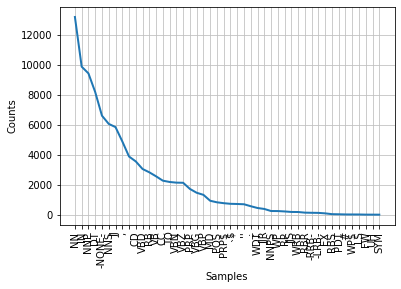

In [12]:
tag_fd.plot()

Finally, let’s look for words that are highly ambiguous as to their POS tag. Understanding why such words are tagged as they are in each context can help us clarify the distinctions among the tags.

Note that the items being counted in the frequency distribution are word-tag pairs, we can then use the NLTK's `ConditionalFreqDist`.
We treat the word as a condition and the tag as an event, and initialize a conditional frequency distribution with a list of condition-event pairs. This lets us see a frequency-ordered list of tags given a word:

In [13]:
data = nltk.ConditionalFreqDist((word, tag) for (word, tag) in nltk.corpus.treebank.tagged_words())
print(data.conditions()[0])
data['The']

Pierre


FreqDist({'DT': 713, 'NNP': 4})

We can print first 10 words along with their POS tags when the word has more than 3 tags.

In [15]:
idx = 0
for word in data.conditions():
    if len(data[word]) > 3:
        tags = list(data[word].keys())
        print (word, ' '.join(tags))
        idx += 1
        if idx >= 10:
            break

the DT NNP JJ CD
a DT JJ IN LS
and CC JJ IN NN
that WDT IN DT RB
in IN RP RB NN
total NN VBP JJ VB
over IN RP RB JJ
further JJ RBR RB JJR
down RP RB IN NN
Japanese JJ NN NNS NNP


> **<h3>❓ Quiz</h3>**

For Brown Corpus, repeat the same process, i.e. plotting the distribution of the tagset and finding the most and least frequent tag. 
What kinds of words occur in the noun, adjective, adverb category? 
Explore the POS tag ditribution of ambiguous words mentioned before, e.g. *content* and *present*. Do they support our observations?



<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
   <p><pre><code>
    # build dictionary where tag is the condition
    tag_word_freq = nltk.ConditionalFreqDist((tag, word) for (word, tag) in nltk.corpus.brown.tagged_words())
    # an example for NN (singular noun)
    # printing the most frequent ten words along with their frequency
    idx = 0
    for word, freq in sorted(tag_word_freq['NN'].items(), key=lambda x: x[1], reverse=True):
        print(word, freq)
        idx += 1
        if idx == 9:
            break     
    # explore the tag distribution of ambiguious words, taking `content` as an example     
    word_tag_freq = nltk.ConditionalFreqDist((word, tag) for (word, tag) in nltk.corpus.brown.tagged_words())
    print('Tag distribution of the word CONTENT:')
    word_tag_freq['content'].plot()
    </code></pre></p> 

### POS tag n-grams
So far we have been working with only a single POS tag in text sequence, i.e. the unigram. 
However, we should be aware that each POS tag in text sequence often depends on its previous/following tags.
For example, nouns can appear after determiners and adjectives, and can be the subject or object of the verb.
Therefore, we can look at some n-gram sequences of POS tags such as tag bi-grams.

Let's build a frequency dictionary of tag bi-grams for the Penn Treebank Corpus using `bi-grams`.

In [16]:
tag_bigram_list = list(nltk.bigrams(nltk.corpus.treebank.tagged_words()))
tag_bigram_fd = nltk.FreqDist((a[1], b[1]) for (a, b) in tag_bigram_list if b[1])
tag_bigram_fd

FreqDist({('NNP', 'NNP'): 3598,
          ('NNP', ','): 1441,
          (',', 'CD'): 115,
          ('CD', 'NNS'): 523,
          ('NNS', 'JJ'): 112,
          ('JJ', ','): 169,
          (',', 'MD'): 54,
          ('MD', 'VB'): 756,
          ('VB', 'DT'): 596,
          ('DT', 'NN'): 3844,
          ('NN', 'IN'): 3210,
          ('IN', 'DT'): 3140,
          ('DT', 'JJ'): 1655,
          ('JJ', 'NN'): 2611,
          ('NN', 'NNP'): 90,
          ('NNP', 'CD'): 190,
          ('CD', '.'): 175,
          ('.', 'NNP'): 699,
          ('NNP', 'VBZ'): 345,
          ('VBZ', 'NN'): 83,
          ('IN', 'NNP'): 1464,
          (',', 'DT'): 660,
          ('DT', 'NNP'): 1050,
          ('NNP', 'VBG'): 7,
          ('VBG', 'NN'): 214,
          ('NN', '.'): 1349,
          ('JJ', 'CC'): 95,
          ('CC', 'JJ'): 237,
          (',', 'VBD'): 268,
          ('VBD', 'VBN'): 300,
          ('VBN', '-NONE-'): 1187,
          ('-NONE-', 'DT'): 352,
          ('JJ', 'JJ'): 371,
          ('.', 'DT

We can see that compared to unigram tag frequency dictionary, bigram dictionary has many more entries, each with smaller frequency. 
It can potentiall cause the data sparsity problmen as we will encounter later.

To validate our intuitions that nouns often occur after the determiners and adjectives, we can investigate the distribution of tag bi-gram **(X, NN)** where **X** refers to any possible tag.

In [17]:
nn_bigram_fd = nltk.FreqDist({k: v for k, v in tag_bigram_fd.items() if k[1] == 'NN'})
sorted_nn_bigram_list = sorted(nn_bigram_fd.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_nn_bigram_list[:20])

[(('DT', 'NN'), 3844), (('JJ', 'NN'), 2611), (('NN', 'NN'), 1658), (('IN', 'NN'), 1080), (('CD', 'NN'), 687), (('NNP', 'NN'), 521), (('POS', 'NN'), 340), (('PRP$', 'NN'), 337), (('CC', 'NN'), 273), ((',', 'NN'), 237), (('VBG', 'NN'), 214), (('VB', 'NN'), 170), (('.', 'NN'), 161), (('VBN', 'NN'), 144), (('NNS', 'NN'), 136), (('-NONE-', 'NN'), 125), (('VBD', 'NN'), 90), (('VBZ', 'NN'), 83), (('JJR', 'NN'), 77), (('``', 'NN'), 71)]


We can see that the two most frequent tags with **(X, NN)** are indeed **DT** (determiner) and **JJ** (adjective) according to the Penn Treebank Corpus tagset.

> **<h3>❓ Quiz</h3>**

Repeat the same process, plot the distribution of tag appearing after adjective in Brown Corpus. 


<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
   <p><pre><code>
    tag_bigram_list = list(nltk.bigrams(nltk.corpus.brown.tagged_words()))
    tag_bigram_fd = nltk.FreqDist((a[1], b[1]) for (a, b) in tag_bigram_list if b[1])
    jj_x_bigram_fd = nltk.FreqDist({k: v for k, v in tag_bigram_fd.items() if k[0] == 'JJ'})
    jj_x_bigram_fd.plot()
    </code></pre></p> 

## Mapping of properties using Python dictionaries
As we have seen, a tagged word of the form **(word, tag)** is an association between a word and a POS tag. 
Once we start doing POS tagging, we will be using such structures extensively.
For example, we want to get the tag list of a given word **(word, tag list)**, or the frequency of a given tag **(tag, freq)**.
We can think of this process as mapping from a certain property to another, and the most natural way to store mappings in Python uses the so-called `dictionary` data type, which we have encountered in module 1 and previous part of this module. 

We look at dictionaries and see how they can represent a variety of language information. 
For example, recall the frequency dictionary we used previously, which maps from a POS tag to its frequency.

In [18]:
tag_fd

FreqDist({'#': 16,
          '$': 724,
          "''": 694,
          ',': 4886,
          '-LRB-': 120,
          '-NONE-': 6592,
          '-RRB-': 126,
          '.': 3874,
          ':': 563,
          'CC': 2265,
          'CD': 3546,
          'DT': 8165,
          'EX': 88,
          'FW': 4,
          'IN': 9857,
          'JJ': 5834,
          'JJR': 381,
          'JJS': 182,
          'LS': 13,
          'MD': 927,
          'NN': 13166,
          'NNP': 9410,
          'NNPS': 244,
          'NNS': 6047,
          'PDT': 27,
          'POS': 824,
          'PRP': 1716,
          'PRP$': 766,
          'RB': 2822,
          'RBR': 136,
          'RBS': 35,
          'RP': 216,
          'SYM': 1,
          'TO': 2179,
          'UH': 3,
          'VB': 2554,
          'VBD': 3043,
          'VBG': 1460,
          'VBN': 2134,
          'VBP': 1321,
          'VBZ': 2125,
          'WDT': 445,
          'WP': 241,
          'WP$': 14,
          'WRB': 178,
          '``': 712

If we want to create a dictionary of the form **(word, tags)**, what types would be for the key and value of the dictionary?

In [23]:
word2tags = {'present': 'V', 'object': 'N'}
for k, v in word2tags.items():
    print('{}: {}'.format(k, word2tags[k]))

present: V
object: N


Here we use word as the key and its corresponding tag as the value.
We use the `string` type for tag, which can be problematic, as both words *present* and *object* can be noun and verb, so if we want to change a tag of *present*, the original tag will be overwritten.

In [24]:
word = 'present'
print('{}: {}'.format(word, word2tags[word]))
word2tags['present'] = 'N'
print('{}: {}'.format(word, word2tags[word]))

present: V
present: N


A better way is to use the mapping **(word (string), tags (list))** for the dictionary.

In [25]:
word2tags = {'present': ['V', 'N'], 'object': ['V', 'N']}
for k, v in word2tags.items():
    print('{}: {}'.format(k, word2tags[k]))

present: ['V', 'N']
object: ['V', 'N']


And if we want to further add a new tag to the word, we can simply `append` it to the tag list.

In [26]:
word = 'present'
print('{}: {}'.format(word, word2tags[word]))
word2tags[word].append('ADJ')
print('{}: {}'.format(word, word2tags[word]))

present: ['V', 'N']
present: ['V', 'N', 'ADJ']


#### Default dictionaries

If we try to access a key that is not in a dictionary, we get an error. 
However, it’s often useful if a dictionary can automatically create an entry for this new key and give it a default value, such as zero or the empty list.
Both **NLTK** and **Python** provide us with the `defaultdict`, a more advanced dictionary, where we can supply a parameter which can be used to create the default value, e.g., int, float, str, list, dict, tuple.
For simplicity, we will stick to the `defaultdict` of NLTK, and for that of Python you can refer to the [link](https://docs.python.org/3/library/collections.html#collections.defaultdict).

Here we build a **(tag, freq)** dictionary, and assign 0 frequency to a new tag *UNK*.

In [27]:
tag_fd_def = nltk.defaultdict(int, tag_fd)
print(tag_fd_def['NN'])
print(tag_fd_def['UNK'])

13166
0


Here we build a **(word, tags)** dictionary, and assign a tag list with the most frequent tag **NN** inside it to a new word.

In [28]:
word2tags_def = nltk.defaultdict(lambda: ['NN'], word2tags)
print(word2tags_def['present'])
print(word2tags_def['a_new_word'])

['V', 'N', 'ADJ']
['NN']


> **<h3>❓ Quiz</h3>**

1. In NLP, one of the preprocessing steps is to replace low-frequency words with a special "out of vocabulary" token, *UNK*, with the help of a default dictionary. Preprocess Brown corpus: keep the most frequent *n* words, and map the rest words to UNK.
2. Create a POS unigram for the Brown Corpus of the mapping **(word, tag_list)**.

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
   <p><pre><code>
    brown_word_freq = nltk.defaultdict(int)
    brown_word_taglist = nltk.defaultdict(list)
    # the cut-off number n
    n = 100
    for word, tag in nltk.corpus.brown.tagged_words():
        brown_word_freq[word] += 1
        brown_word_taglist[word].append(tag)
    for i, (word, freq) in enumerate(sorted(brown_word_freq.items(), key=lambda x: x[1], reverse=True)):
        if i >= 100:
            brown_word_freq['UNK'] += freq
            del brown_word_freq[word]
    </code></pre></p> 

### POS tag n-grams for tagging
We can use default dictionaries with complex keys and values to build tag n-grams for tagging.

Taking bi-gram as an example, we want to store the frequency of tag **t2**, which depends on the tag **t1** of its previous word, and the current word **w2**.

In [29]:
# create a nested default dictionary, where the value is another default dictionary whose default value is int (0)
pos = nltk.defaultdict(lambda: nltk.defaultdict(int))
# create bigrams of (word, tag) pair
for ((w1, t1), (w2, t2)) in nltk.bigrams(nltk.corpus.treebank.tagged_words()):
    pos[(t1, w2)][t2] += 1
print(pos[('DT', 'right')])

defaultdict(<class 'int'>, {'NN': 17, 'JJ': 2, 'RB': 1})


Each time through the loop we updated our `pos` entry for **(t1, w2)**, a tag and its following word. 
When we look up an item in `pos` we must specify a compound key , and we get back a dictionary object. 
A POS tagger could use such information to decide that the word *right*, when preceded by a determiner, should be tagged as one of the tags in *NN*, *JJ*, and *RB*.

## Automatic Tagging

We will explore various ways to automatically perform POS tagging. We will see that the tag of a word depends on the word and its context within a *sentence*. 
For this reason, we will be working with data at the level of (tagged) sentences rather than words. 

We’ll begin by loading the Penn Treebank data we will be using.

In [3]:
penn_tagged_sents = nltk.corpus.treebank.tagged_sents()
penn_sents = nltk.corpus.treebank.sents()

### Data Split

As we mentioned earlier, for most machine learning POS taggers, a split of the original dataset into the *training* set and *test* set is necessary.
Training and testing a model on a single dataset can easily lead to the problem of [overfitting](https://en.wikipedia.org/wiki/Overfitting), as a tagger that simply memorized its training data and made no attempt to construct a general model would get a perfect score, but would be useless for tagging new text. 
Therefore, another held-out test set is used after training the model with training set to evaluate the generalizability of the model.

In this section, we split the data, training on 90% and testing on the remaining 10%, and this proportion may vary depending on the task and data size.

In [4]:
train_prop = 0.9
size = int(len(penn_tagged_sents) * train_prop)
train_tagged_sents = penn_tagged_sents[:size]
test_tagged_sents = penn_tagged_sents[size:]
train_sents = penn_sents[:size]
test_sents = penn_sents[size:]
print('Training sents: {} {}'.format(len(train_sents), len(train_tagged_sents)))
print('Test sents: {} {}'.format(len(test_sents), len(test_tagged_sents)))

Training sents: 3522 3522
Test sents: 392 392


Now we split the original annotated dataset into a training and test set. we will evaluate **ALL** taggers on the test set, and use training data for taggers that require data to train on.

> **<h3>❓ Quiz</h3>**

1. Create the tag distribution plot of both *training* and *test* set of Penn Treebank Corpus, and compare them with the plot of the whole corpus. What difference can you see?
2. Calculate the out-of-vocabulary (OOV) rate between the training and test sets:
    - report the number of tokens and token types in the 90% training set;
    - report the number of tokens and token types in the 10% test set;
    - report the TEST token OOV rate and token type OOV rate, i.e. percentage of words in test that are not present in training. 

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
   <p><pre><code>
   # full data
    tag_fd = nltk.FreqDist(tag for sent in penn_tagged_sents for (word, tag) in sent)
    tag_fd.plot()
    # training data
    train_tag_fd = nltk.FreqDist(tag for sent in train_tagged_sents for (word, tag) in sent)
    train_tag_fd.plot()
    # test data
    test_tag_fd = nltk.FreqDist(tag for sent in test_tagged_sents for (word, tag) in sent)
    test_tag_fd.plot()
    # number of tokens and token types in training data
    train_token_freq = nltk.defaultdict(int)
    for sent in train_tagged_sents: 
        for (word, tag) in sent:
            train_token_freq[word] += 1
    print(f'Training: {sum(train_token_freq.values())}, {len(train_token_freq.keys())}')
    # number of tokens and token types in test data
    test_token_freq = nltk.defaultdict(int)
    for sent in test_tagged_sents: 
        for (word, tag) in sent:
            test_token_freq[word] += 1
    print(f'Test: {sum(test_token_freq.values())}, {len(test_token_freq.keys())}')
    # OOV rate
    OOV_token = .0
    OOV_token_type = .0
    for t_token, t_freq in test_token_freq.items():
        # test token not exists in train data
        if t_token not in train_token_freq:
            OOV_token += t_freq
            OOV_token_type += 1
    print(f'Test OOV rate: {OOV_token / sum(test_token_freq.values()) * 100:.2f}%, {OOV_token_type / len(test_token_freq.keys()) * 100:.2f}%')
    </code></pre></p> 

### Evaluation

Evaluation is another core part of NLP.
When evaluating our models on test set annotated by human experts, what numbers are we going to report? An intuitive one is the *accuracy* comparing the gold standard test set tags and the predicted tags produced by the model, i.e. the percentage of correct tags the model has predicted.

Recall the term *presicion*, *recall* and *F1-score* for 2-class classification in previous modules, it is still applicable in POS tagging, where we can have these number for EACH POS tag category (NN v.s. non NN). We can achieve this by building a *confusion matrix* of the outputs.

Let's use the tagger in the very beginning of the section and create such confusion matrix:

In [5]:
gold_test_tags = [tag for test_tagged_sent in test_tagged_sents for (word, tag) in test_tagged_sent]
pred_test_tags = [tag for test_sent in test_sents for (word, tag) in nltk.pos_tag(test_sent)]
print(nltk.ConfusionMatrix(gold_test_tags, pred_test_tags).pretty_format())

       |                        -                                                                                                                                                                                          |
       |                   -    N    -                                                                                                                                                                                     |
       |                   L    O    R                                                                          N                        P                                                                                 |
       |                   R    N    R                                                 J    J              N    N    N    P    P    P    R         R    R                   V    V    V    V    V    W         W    W      |
       |         '         B    E    B              C    C    D    E    F    I    J    J    J    M    N    N    P   

As we can see, the row values indicate the POS tags given by reference (gold standard test set), and the column tags are from the model output.

In order to calculate the metrics we mentioned earlier, let's first read the whole matrix in:

In [8]:
cm = nltk.ConfusionMatrix(gold_test_tags, pred_test_tags)
cm_matrix = np.array(cm._confusion)
print(cm_matrix)

[[ 98   0   0 ...   0   0   0]
 [  0  42   0 ...   0   0   0]
 [  0   0 434 ...   0   0   0]
 ...
 [  0   0   0 ...   4   0   0]
 [  0   0   0 ...   0  17   0]
 [  0   0   0 ...   0   0  43]]


The total number of tags are just the sum of the matrix value, where you can verify from the previous quiz.

In [9]:
total_tags = np.sum(cm_matrix)
total_tags

9825

*Accuracy* is simply the ratio between the correct tags (sum of the diagnoal value called *trace*) and total tag number.

In [10]:
acc = np.trace(cm_matrix) / total_tags
acc

0.8926208651399491

Taking **NN** as an example, we want to calualte the *precision*, *recall* and *F1-score*.
First we need to calculate true positive, false positive and false negative.
True positive is simply the entry where both row and column are **NN**.

In [13]:
nn_idx = cm._indices['NN']
tp = cm_matrix[nn_idx][nn_idx]
tp

1344

False positive is the sum of *NN* column (all model predicted *NN*) values exluding true positive (correctly predicted *NN*). 

In [14]:
fp = sum(cm_matrix[:, nn_idx]) - tp
fp

220

Similarly, False negative is the sum of *NN* row (all gold/real *NN*) values exluding true positive.

In [15]:
fn = sum(cm_matrix[nn_idx, :]) - tp
fn

100

The precision, recall and F1-score can be caclculated accordingly:

In [16]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(precision, recall, f1)

0.8593350383631714 0.9307479224376731 0.8936170212765957


> **<h3>💻 Try it yourself!</h3>**

Calculate the three metrics for POS tags you are interested in with the same tagger, and complete the table below.

| POS           | Precision     | Recall  | F1-score 
| ------------- |---------------|---------|----------
| NN      | 85.9 | 93.1 | 89.4 
| JJ      |      |      |      
| Add tag here   |      |      |      

### Default tagger
The simplest possible tagger assigns the same tag to each token. This may seem to be a rather banal step, but it establishes an important baseline for tagger performance. 
In order to get the best result, we tag each word with the most likely tag.

In [17]:
nltk.FreqDist(gold_test_tags).max()

'NN'

Now we can create a tagger that tags everything as **NN**.

In [18]:
default_tagger = nltk.DefaultTagger('NN')
default_preds = [(word, tag) for test_sent in test_sents for (word, tag) in default_tagger.tag(test_sent)]
default_preds[:10]

[('Kalamazoo', 'NN'),
 (',', 'NN'),
 ('Mich.-based', 'NN'),
 ('First', 'NN'),
 ('of', 'NN'),
 ('America', 'NN'),
 ('said', 'NN'),
 ('0', 'NN'),
 ('it', 'NN'),
 ('will', 'NN')]

The accuracy of this tagger is

In [19]:
default_pred_test_tags = [tag for (word, tag) in default_preds]
default_cm = nltk.ConfusionMatrix(gold_test_tags, default_pred_test_tags)
default_cm_matrix = np.array(default_cm._confusion)
acc = np.trace(default_cm_matrix) / np.sum(default_cm_matrix)
acc

0.14697201017811704

Alternatively, we can directly calculate accuracy with `evaluate()`.

In [20]:
acc_sys = default_tagger.evaluate(test_tagged_sents)
acc_sys

0.14697201017811704

> **<h3>💻 Try it yourself!</h3>**

Calculate the three metrics for POS tags you are interested in with the **default** tagger, and complete the table below.

| POS           | Precision     | Recall  | F1-score 
| ------------- |---------------|---------|----------
| NN            |  |  |  
| JJ             |      |      |      
| Add tag here  |      |      |      

### The most frequent 100 unigram tagger
A lot of high-frequency words do not have the **NN** tag. 
Let’s find the 100 most frequent words and store their most likely tags. We can then use this information as the
model for a *lookup tagger*, which is an NLTK UnigramTagger.

In [21]:
# create a FreqDist of word unigram from training corpus
fd = nltk.FreqDist([word for train_tagged_sent in train_tagged_sents for (word, tag) in train_tagged_sent])
# get the 100 most frequent unigram word 
most_freq_words = list(fd.keys())[:100]
# create a ConditionalFreqDist associating the word and POS tags
cfd = nltk.ConditionalFreqDist([(word, tag) for train_tagged_sent in train_tagged_sents for (word, tag) in train_tagged_sent])
# get the most likely tag for each word
likely_tags = dict((word, cfd[word].max()) for word in most_freq_words)
print(likely_tags)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
baseline_tagger.evaluate(test_tagged_sents)

{'Pierre': 'NNP', 'Vinken': 'NNP', ',': ',', '61': 'CD', 'years': 'NNS', 'old': 'JJ', 'will': 'MD', 'join': 'VB', 'the': 'DT', 'board': 'NN', 'as': 'IN', 'a': 'DT', 'nonexecutive': 'JJ', 'director': 'NN', 'Nov.': 'NNP', '29': 'CD', '.': '.', 'Mr.': 'NNP', 'is': 'VBZ', 'chairman': 'NN', 'of': 'IN', 'Elsevier': 'NNP', 'N.V.': 'NNP', 'Dutch': 'JJ', 'publishing': 'NN', 'group': 'NN', 'Rudolph': 'NNP', 'Agnew': 'NNP', '55': 'CD', 'and': 'CC', 'former': 'JJ', 'Consolidated': 'NNP', 'Gold': 'NNP', 'Fields': 'NNP', 'PLC': 'NNP', 'was': 'VBD', 'named': 'VBN', '*-1': '-NONE-', 'this': 'DT', 'British': 'JJ', 'industrial': 'JJ', 'conglomerate': 'NN', 'A': 'DT', 'form': 'NN', 'asbestos': 'NN', 'once': 'RB', 'used': 'VBN', '*': '-NONE-', 'to': 'TO', 'make': 'VB', 'Kent': 'NNP', 'cigarette': 'NN', 'filters': 'NNS', 'has': 'VBZ', 'caused': 'VBN', 'high': 'JJ', 'percentage': 'NN', 'cancer': 'NN', 'deaths': 'NNS', 'among': 'IN', 'workers': 'NNS', 'exposed': 'VBN', 'it': 'PRP', 'more': 'JJR', 'than': 'IN

0.32111959287531805

Let's try to tag some sentence:

In [22]:
baseline_tagger.tag(train_sents[6])

[('Although', None),
 ('preliminary', None),
 ('findings', None),
 ('were', None),
 ('reported', 'VBD'),
 ('*-2', None),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('a', 'DT'),
 ('year', None),
 ('ago', 'IN'),
 (',', ','),
 ('the', 'DT'),
 ('latest', None),
 ('results', None),
 ('appear', None),
 ('in', None),
 ('today', None),
 ("'s", None),
 ('New', 'NNP'),
 ('England', None),
 ('Journal', None),
 ('of', 'IN'),
 ('Medicine', None),
 (',', ','),
 ('a', 'DT'),
 ('forum', None),
 ('likely', None),
 ('*', '-NONE-'),
 ('to', 'TO'),
 ('bring', None),
 ('new', None),
 ('attention', None),
 ('to', 'TO'),
 ('the', 'DT'),
 ('problem', None),
 ('.', '.')]

We can see that many words have been assigned a tag of **None**, because they were not among the 100 most frequent words. In these cases we would like to assign the default tag of **NN**. In other words, we want to use the lookup table first, and if it is unable to assign a tag, then use the default tagger, a process known as **backoff**.

In [23]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags, 
                                     backoff=nltk.DefaultTagger('NN'))

Now the lookup tagger will only store word-tag pairs for words other than nouns, and whenever it cannot assign a tag to a word, it will invoke the default tagger.

In [24]:
baseline_tagger.evaluate(test_tagged_sents)

0.46575063613231554

And tagging the same sentence will give us different results now, where **None** is substituted by **NN**.

In [25]:
baseline_tagger.tag(train_sents[6])

[('Although', 'NN'),
 ('preliminary', 'NN'),
 ('findings', 'NN'),
 ('were', 'NN'),
 ('reported', 'VBD'),
 ('*-2', 'NN'),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('a', 'DT'),
 ('year', 'NN'),
 ('ago', 'IN'),
 (',', ','),
 ('the', 'DT'),
 ('latest', 'NN'),
 ('results', 'NN'),
 ('appear', 'NN'),
 ('in', 'NN'),
 ('today', 'NN'),
 ("'s", 'NN'),
 ('New', 'NNP'),
 ('England', 'NN'),
 ('Journal', 'NN'),
 ('of', 'IN'),
 ('Medicine', 'NN'),
 (',', ','),
 ('a', 'DT'),
 ('forum', 'NN'),
 ('likely', 'NN'),
 ('*', '-NONE-'),
 ('to', 'TO'),
 ('bring', 'NN'),
 ('new', 'NN'),
 ('attention', 'NN'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('problem', 'NN'),
 ('.', '.')]

> **<h3>💻 Try it yourself!</h3>**

Calculate the three metrics for POS tags you are interested in with the **lookup** tagger with **backoff**, and complete the table below.

| POS           | Precision     | Recall  | F1-score 
| ------------- |---------------|---------|----------
| NN            |  |  |  
| JJ             |      |      |      
| Add tag here  |      |      |      

## N-gram tagging

The previous 100 most frequent lookup tagger is essentially a **unigram** tagger, where we consider only the current token, in isolation from any larger context. 
Given such a model, the best we can do is to tag each word with its a *priori* most likely tag learned from the training data. 
This means we would tag a word such as *wind* with the same tag, regardless of whether it appears in the context *the wind* or *to wind*.

An n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the POS tags of the $n-1$ preceding tokens, as shown below. 

![ngram_tagger](https://github.com/cambridgeltl/python4cl/blob/module_2.3/module_2/module_2.3/ngram_tagger.jpg?raw=1)

Here the tag to be chosen, $t_n$, is circled, and the context is shaded in grey. 
In the example of an n-gram tagger, we have $n=2$, i.e. a **tri-gram** tagger; that is, the model will pick the most likely $t_n$ given the 2 preceding tags in addition to the current word.

Recall again the unigram tagger, we have $n=0$, where it doesn't consider any previous word tags, but only the current word token.

### Bi-gram tagger

Ideally, when we have larger $n$, the model will learn more specific situations which can be potentially helpful for our tagging.
However, given the limited training data, the model will also learn either too specific or irrelevant information (noise) which cannot generalize well to the test data.
We call this data sparsity problem.

Consider the following example:
```
I/PRP really/RB like/VBP to/TO **wind** ...

I/PRP like/VBP to/TO **wind** ...
```
Now if we want to decide the tag of the word **wind**, for a tri-gram tagger, both sentences will give us the same information: (VPB, TO, wind).
However, if we use a 4-gram tagger, the first sentence will give us (RB, VBP, TO, wind) whereas the second one will give us (PRP, VBP, TO, wind).
It will
1. reduce the signal of (VPB, TO, wind) which is useful for tagging, as (RB, VBP, TO, wind) and (PRP, VBP, TO, wind) will be counted separately once where in trigram tagger (VPB, TO, wind) will be counted twice, which is the main cause of data sparsity.
2. learn irrelevant information from (RB, VBP, TO, wind) and (PRP, VBP, TO, wind) as the first tag really doesn't help us better in tagging in general.

As a consequence, there is always a trade-off between the accuracy and the coverage of our results, which is closely related to the concept of overfitting, where for a certain amount of training data, we do not want our model to be too complex to perform well on the training data, but cannot generalize on real-world unseen data.

Generally, in NLP practice, a **bi-gram** tagger is sufficient to obtain a good test performance for the POS tagging.

In [26]:
# train the tagger with training data
t2 = nltk.BigramTagger(train_tagged_sents)
# evaluate the tagger on the test data
t2.evaluate(test_tagged_sents)

0.13455470737913486

In [27]:
t2.tag(train_sents[6])

[('Although', 'IN'),
 ('preliminary', 'JJ'),
 ('findings', 'NNS'),
 ('were', 'VBD'),
 ('reported', 'VBN'),
 ('*-2', '-NONE-'),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('a', 'DT'),
 ('year', 'NN'),
 ('ago', 'IN'),
 (',', ','),
 ('the', 'DT'),
 ('latest', 'JJS'),
 ('results', 'NNS'),
 ('appear', 'VBP'),
 ('in', 'IN'),
 ('today', 'NN'),
 ("'s", 'POS'),
 ('New', 'NNP'),
 ('England', 'NNP'),
 ('Journal', 'NNP'),
 ('of', 'IN'),
 ('Medicine', 'NNP'),
 (',', ','),
 ('a', 'DT'),
 ('forum', 'NN'),
 ('likely', 'JJ'),
 ('*', '-NONE-'),
 ('to', 'TO'),
 ('bring', 'VB'),
 ('new', 'JJ'),
 ('attention', 'NN'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('problem', 'NN'),
 ('.', '.')]

In [28]:
t2.tag(test_sents[6])

[('After', 'IN'),
 ('these', 'DT'),
 ('payments', 'NNS'),
 (',', ','),
 ('about', 'IN'),
 ('$', '$'),
 ('225,000', None),
 ('*U*', None),
 ('will', None),
 ('be', None),
 ('available', None),
 ('for', None),
 ('the', None),
 ('20', None),
 ('million', None),
 ('common', None),
 ('shares', None),
 ('outstanding', None),
 ('.', None)]

We can see that the the default bi-gram tagger can tag sentences in the training data pretty well, but fails to tag the test data sentence and yields a lot of **None** tags.
It is still eseentially a look-up tagger, and when the tagger encounters a new combination of (previous_tag, current_word), it will output **None** as the predicted tag and immediately propagate to the following predictions with (None, current_word) tuples, as the tagger has never seen the tag **None** in training data.

There are two ways to remedy for that:
- As seen previously, we can use **backoff** to combine bi-gram tagger with unigram and default tagger.
- Use a more sophisticated bi-gram tagging model, which we will see later.

In [29]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_tagged_sents, backoff=t0)
t2 = nltk.BigramTagger(train_tagged_sents, backoff=t1)
t2.evaluate(test_tagged_sents)

0.8905852417302799

> **<h3>❓ Quiz</h3>**

Build a bi-gram look-up tagger with back-off, where it first falls back to the unigram tagger, and then the default tagger with *NN* as the default tag.

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
   <p><pre><code>
    t0 = nltk.DefaultTagger('NN')
    t1 = nltk.UnigramTagger(train_tagged_sents, backoff=t0)
    t2 = nltk.BigramTagger(train_tagged_sents, backoff=t1)
    t2.evaluate(test_tagged_sents)
    </code></pre></p> 

> **<h3>💻 Try it yourself!</h3>**

Calculate the three metrics for POS tags you are interested in with the **bi-gram lookup** tagger with **backoff**, and complete the table below.

| POS           | Precision     | Recall  | F1-score 
| ------------- |---------------|---------|----------
| NN            |  |  |  
| JJ             |      |      |      
| Add tag here  |      |      |      

### Hidden Markov Model (HMM) Bi-gram Tagger

The bad performance of the bi-gram look-up tagger is mainly caused by 
1. The direct use of the bi-gram information $p(t_i | w_i, t_{i-1})$ without considering internal structures between tags and words; 
2. Greedy decoding at each step not taking the previous tagged results into account.

Here we introduce a more sophisticated bi-gram tagger called hidden Markov model (HMM) tagger.
In general, given a sequence of texts with length $n$ $w_1^n$, e.g. sentence, an HMM tagger tries to find the tag sequence $\hat{t}_1^n$ with the highest probability:

$$
\begin{aligned}
\hat{t}_1^n &= \arg\max_{t_1^n} p(t_1^n | w_1^n)\\ 
&= \arg\max_{t_1^n} \frac{p(w_1^n | t_1^n)p(t_1^n)}{p(w_1^n)}\qquad\textrm{Bayes rule}\\
&= \arg\max_{t_1^n} p(w_1^n | t_1^n)p(t_1^n)\qquad\textrm{Because $p(w_1^n)$ does not effect the selection of $\hat{t}_1^n$.}
\end{aligned}
$$

where
$$
p(w_1^n | t_1^n) = p(w_1, w_2, ..., w_n | t_1, t_2, ..., t_n) \approx \sum_{i=1}^n p(w_i | t_i) \\
$$
with the assumption that tag $t_i$ is the **hidden** variable that only determines the observation word $w_i$, and

$$
p(t_1^n) = p(t_1, t_2, ..., t_n) = \underbrace{\sum_{i=1}^n p(t_i | t_1, ... t_{i-1})}_\textrm{chain rule} \approx \sum_{i=1}^n p(t_i | t_{i-1})
$$
assuming the first-order **Markov** process, corresponding to bi-gram tag, where each state (variable) is only dependent on the immediately previous state.


With the previous two assumptions, we can rewrite the equation for HMM bi-gram tagger:
$$
\hat{t}_1^n \approx \arg\max_{t_1^n} \sum_{i=1}^n \underbrace{p(w_i | t_i)}_\textrm{emission}\underbrace{p(t_i | t_{i-1})}_\textrm{transition}
$$
where we have the emission probability $p(w_i | t_i) = \frac{C(t_i, w_i)}{C(t_i)}$ and transition probability $p(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_i)}{C(t_i)}$ for each step $i$, and here $C(\cdot)$ means the count or frequency for corresponding variables that we obtain from the training data.

In practice we can use a [matrix](https://en.wikipedia.org/wiki/Matrix_(mathematics)) $A = a_{ij}$ to denote the transition probability from $t_i$ to $t_j$ and a dictionary B to store emission probability $p(w_i | t_i)$ = B[$t_i$][$w_i$].

We use HMM bi-gram tagger to address the problem 1 of the look-up tagger, and during decoding (equivalent to prediction/inference) we use **Viterbi algorithm** to address the problem 2 for greedy decoding.
We show the algorithm of Viterbi algorithm from J&M 3 book, and please refer to the original book [link](http://web.stanford.edu/~jurafsky/slp3/8.pdf) for more details.

The intuition behind the algorithm is that the best path of length $t$ ending in a particular tag must include the best path of length $t-1$ ending in the previous tag.
Each step forward uses the probability of the pathway at the previous step, the conditional probability of the next tag given the current tag, and the probability of seeing a word given the current tag.

![viterbi](https://github.com/cambridgeltl/python4cl/blob/module_2.3/module_2/module_2.3/viterbi.jpg?raw=1)

Let's first create an HMM tagger and train it with training data.

In [30]:
hmm_tagger = nltk.HiddenMarkovModelTagger.train(train_tagged_sents)

Then we can try to tag some sentences with the model.

In [31]:
hmm_tagger.test(test_tagged_sents[:2], verbose=True)

Test: Kalamazoo/NNP ,/, Mich.-based/JJ First/NNP of/IN America/NNP said/VBD 0/-NONE- it/PRP will/MD eliminate/VB the/DT 13/CD management/NN positions/NNS of/IN the/DT former/JJ Midwest/NNP Financial/NNP parent/NN company/NN ./.

Untagged: Kalamazoo , Mich.-based First of America said 0 it will eliminate the 13 management positions of the former Midwest Financial parent company .

HMM-tagged: Kalamazoo/NNP ,/, Mich.-based/NNP First/NNP of/IN America/NNP said/VBD 0/-NONE- it/PRP will/MD eliminate/VB the/DT 13/CD management/NN positions/NNS of/IN the/DT former/JJ Midwest/NNP Financial/NNP parent/NN company/NN ./.

Entropy: 15.04151334639123

------------------------------------------------------------
Test: First/NNP of/IN America/NNP said/VBD 0/-NONE- some/DT of/IN the/DT managers/NNS will/MD take/VB other/JJ jobs/NNS with/IN First/NNP of/IN America/NNP ./.

Untagged: First of America said 0 some of the managers will take other jobs with First of America .

HMM-tagged: First/NNP of/IN Am

We evaluate the HMM tagger on the test data.

In [32]:
hmm_tagger.evaluate(test_tagged_sents)

0.8993384223918575

Now let's visualize the viterbi algorithm with a revised HMM tagger (You don't have to understand the code here).

In [33]:
def _identity(labeled_symbols):
    return labeled_symbols

class RevisedHiddenMarkovModelTagger(nltk.HiddenMarkovModelTagger):
    def __init__(self, symbols, states, transitions, outputs, priors, transform=_identity):
        super(RevisedHiddenMarkovModelTagger, self).__init__(symbols, states, transitions, outputs, priors, transform=transform)
    
    def _best_path(self, unlabeled_sequence):
        T = len(unlabeled_sequence)
        N = len(self._states)
        self._create_cache()
        self._update_cache(unlabeled_sequence)
        # P is the log prior probability tags (T)
        # O is log omission probability (T, vocab_size)
        # X is log transition probability (T, T)
        # S is idx -> token dict (vocab_size)
        P, O, X, S = self._cache
        
        # V is the log proability for tag path (T, N)
        # B is the tag path (T, N)
        V = np.zeros((T, N), np.float32)
        B = -np.ones((T, N), np.int)
        
        # initialization, log(prior(t)) + log(p_o(w_1 | t))
        V[0] = P + O[:, S[unlabeled_sequence[0]]]
        # start from the second token of the sequence
        for t in range(1, T):
            # iterate over all possible tags 
            for j in range(N):
                # log(p_previous_seq_end_in_any_tag) + log(p(tag_j | tag_any))
                vs = V[t - 1, :] + X[:, j]
                # pick the tag that maximizes vs: log(p_previous_seq_end_in_tag_best) + log(p(tag_j | tag_best))
                best = np.argmax(vs)
                # log(p_previous_seq_end_in_tag_best) + log(p(tag_j | tag_best)) + log(p(w_t | tag_j))
                V[t, j] = vs[best] + O[j, S[unlabeled_sequence[t]]]
                B[t, j] = best # previous tag index is `best`
                
        # get best seq, along with the last tag index `current`
        current = np.argmax(V[T - 1, :])
        sequence = [current]
        # trace back tag sequence
        for t in range(T - 1, 0, -1):
            # get the previous tag index `last`
            last = B[t, current]
            sequence.append(last)
            current = last

        sequence.reverse()
        # map the tag sequence id to the actual tag
        return list(map(self._states.__getitem__, sequence)), V, B, O, X

In [34]:
revised_hmm_tagger = RevisedHiddenMarkovModelTagger.train(train_tagged_sents)

We now visualize a single test sentence.

In [35]:
test_sent_idx = 6 # you can change the index to test different sentences
print(test_sents[test_sent_idx])
best_path, V, B, O, X = revised_hmm_tagger.best_path(test_sents[test_sent_idx])
print(best_path)

['After', 'these', 'payments', ',', 'about', '$', '225,000', '*U*', 'will', 'be', 'available', 'for', 'the', '20', 'million', 'common', 'shares', 'outstanding', '.']
['IN', 'DT', 'NNS', ',', 'IN', '$', 'CD', '-NONE-', 'MD', 'VB', 'JJ', 'IN', 'DT', 'CD', 'CD', 'JJ', 'NNS', 'JJ', '.']


In [36]:
# convert backpoint B to corresponding tag
id2tag = {i: t for i, t in enumerate(revised_hmm_tagger._states)}
id2tag[-1] = '<S>'
tag2id = {v: k for k, v in id2tag.items()}
f = np.vectorize(lambda x: id2tag[x])
B_tag = f(B.T)

['IN', 'DT', 'NNS', ',', 'IN', '$', 'CD', '-NONE-', 'MD', 'VB', 'JJ', 'IN', 'DT', 'CD', 'CD', 'JJ', 'NNS', 'JJ', '.']


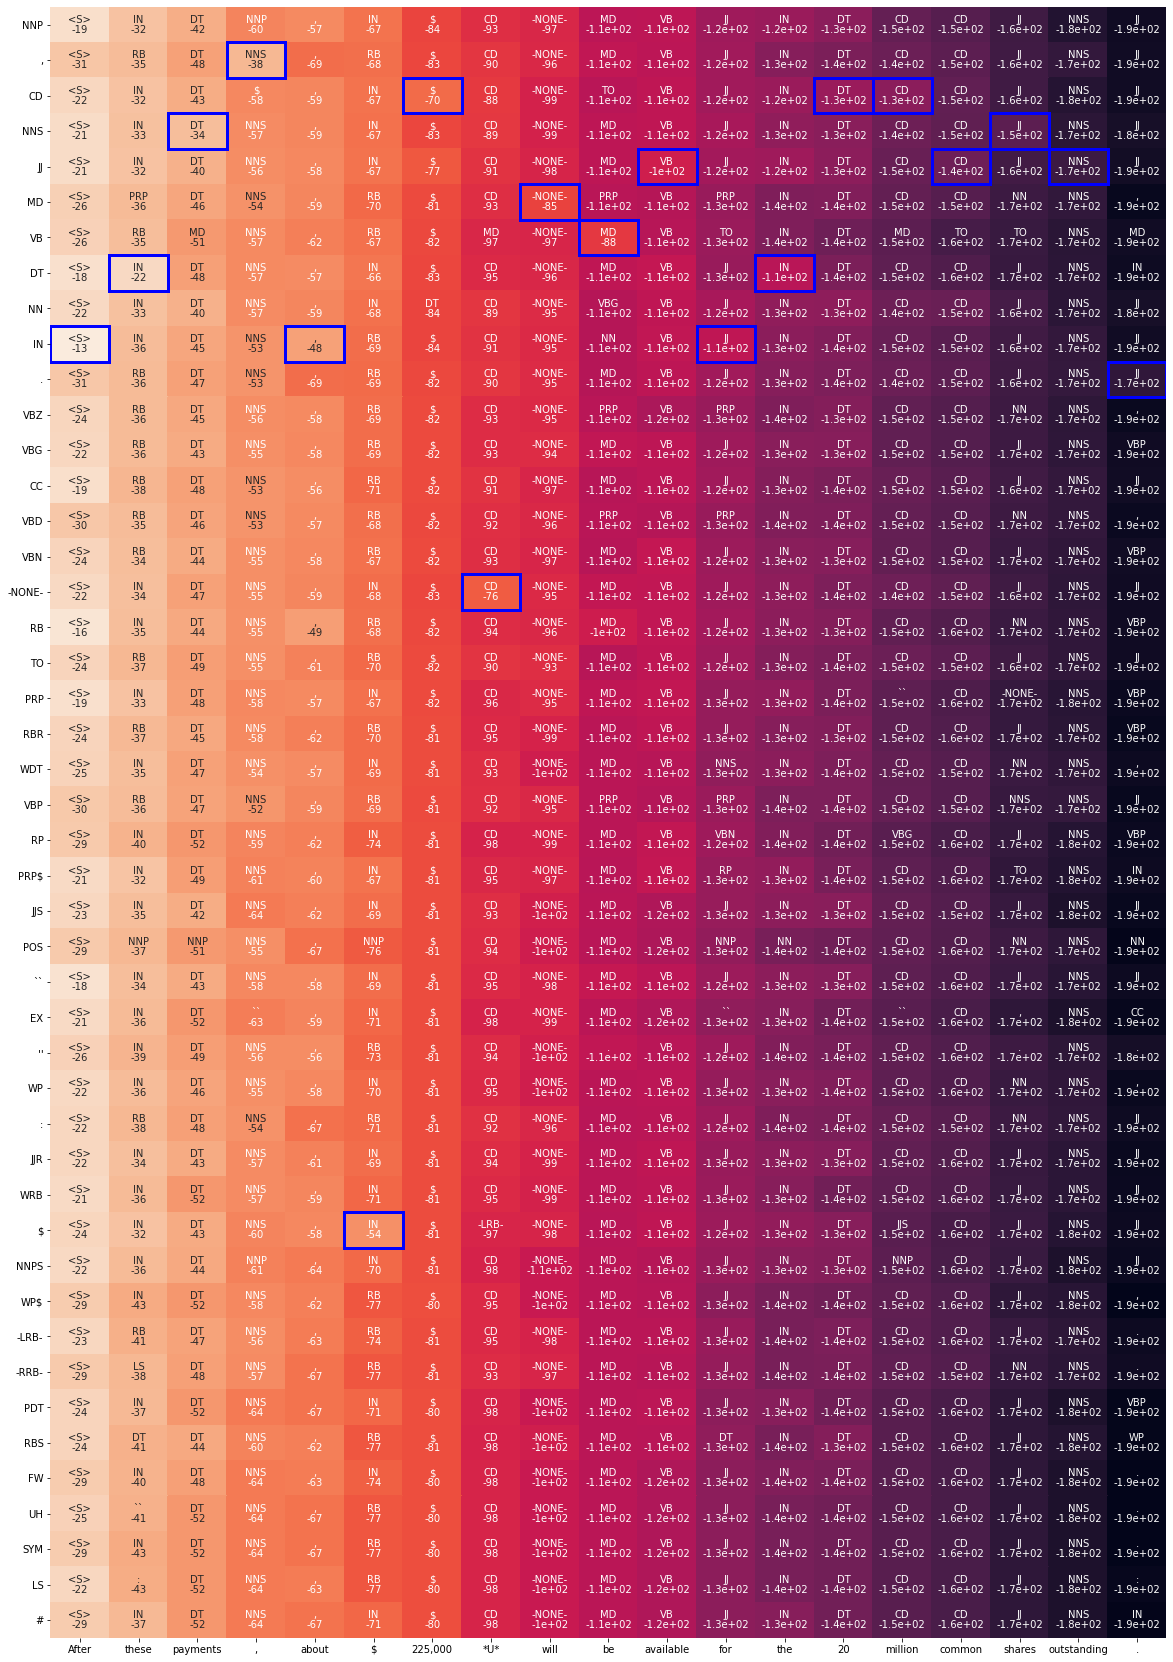

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

print(best_path)

plt.figure(figsize = (20, 30))
ax = sns.heatmap(V.T,
                 cbar=False,
                 annot=B_tag,
                 annot_kws={'va':'bottom'},
                 fmt="")
ax = sns.heatmap(V.T, 
                 cbar=False, 
                 annot=True,
                 xticklabels=test_sents[test_sent_idx],
                 yticklabels=revised_hmm_tagger._states,
                 annot_kws={'va':'top'},
                )
for i, t in enumerate(best_path):
    ax.add_patch(Rectangle((i, tag2id[t]), 1, 1, edgecolor='blue', fill=False, lw=3))
plt.show()

Here the rows represent all possible tags (all tags in the tagset), and the colums show each token of the sentence. The value of the heatmap is the log probability of the tagged setences ending with a specific tag in the previous step, and the blue box shows the selected tag for each step.

## ✍️ Final Assessment

1. Run the HMM bi-gram tagger trained on the **full** Penn Treebank on this made-up sentence 
```
@Will WOOOHOO Will the New jPhone bOut 2night? Soexcited :)
```
Does the tagger get the correct answer?  Write down two challenges the tagger has incorrectly resolved.

2. For Brown Corpus, Write a program to find out:

a. which word has the most POS tags and tag types in the corpus.

b. what percentage of words in the corpus are ambiguous, i.e. have more than one POS tag.

3. Write a program to replace low frequency words (words with a frequency of 5 or less) with UNK in the **full** Penn Treebank corpus. 
What is the F-score of your bi-gram backoff tagger (fall back to unigram model, and then to the default tagger with `NN` as the default tag) on the Penn Treebank test set using the same train/test split previously? 

## Additional resources

- Chapter 5 about part-of-speech tagging from the book [Natural Language Processing with Python](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).
- [NLTK library documentation](https://www.nltk.org/).
- Chapter 8 about part-of-speech tagging from the book [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/8.pdf).